In [1]:
from CoolProp.CoolProp import PropsSI
import random 
# use the letters:
# ... T for (T)emperature 
# ... P for (P)ressure
# ... D for (D)ensity (use the density to calculate the specific volume)
# ... Q for vapor quality x

<img src="basic-CAES-model.png">

In [22]:
#Boundary conditions and constants

#Ambiant air
p1 = 1.013e5   # Pa
T1 = 273.15+20 # K
Ra = 287.06    # J/kgK
cp = 1059.7    # J/kgK

#Miscellaneous
gamma = cp/(cp-Ra) #[-]
Pwind = 300e6      # W
t_rampup = 15*60   # s
T3 = 893.15        # K
T4 = 323.15        # K
T5 = 873.15        # K
mdot_max = 500     # kg/s

#Cavern
V = 500000    # m^3         
p4max = 150e5 # Pa       
p4min = 100e5 # Pa

#TES 
eff_TES = 0.977

#Compressor
eff_c   = 0.875 #[-]
n_c = eff_c*gamma/(eff_c*gamma-gamma+1) #[-]
Pc_max = 300e6 # max compressor power

#Turbine
eff_t   = 0.925 #[-]
n_t = eff_t*gamma/(eff_t*gamma-gamma+1) #[-]
Pt_max = 300e6 # max turbine power

#Motor & Generator
eff_m = 0.98 #[-]
eff_g = 0.98 #[-]



#Functions

#Input power, including start up time compressor, without eff_m
def Pin(t):
    if t > t_rampup:
        Pin = Pwind
    else:
        Pin = Pwind*t/t_rampup
    return Pin

#Isothermal relation for temperature after compression, p4 = p2 = pcavern = f(t)
#According to paper the results should be 1120K for 100 bar and 1255K for 150 bar
#Formula with compressor efficiency models this better, should we change this @Walid
def Tcompr():
    T2=T1*(p4/p1)**((gamma-1)/gamma)
    return T2



#Starting conditions

#Initial pressure in cavern
p4 = p4min

t=15*60 #Test value, should be t=0 for model and change in loop



#Other code

#Specific work theoretical equation
#Will change bc p4 = f(t)
dh = n_c/(n_c-1)/eff_c*Ra*T1*((p4/p1)**((n_c-1)/n_c)-1)

#Specific heat reduction for temperature restrictions (q23)
#Will change bc Tcompr = f(p4) and p4 = f(t)
q = cp*(T3-Tcompr()) # multiply by mdot?

# mass flow as a function of time
def mdot(t):
    return Pin(t)/(dh/eff_m+abs(q))

print(dh)
print(q)
print(mdot(t))

976734.9026210735
-131306.8493405779
265.96331372313


In [23]:
# TES, cavern and turbine

p5 = p4 # Assuming no pressure loss over TES


def q34dot(t):
    return mdot(t)* cp *(T4 - (T3-20))
    

In [24]:
import matplotlib.pyplot as plt
import numpy as np

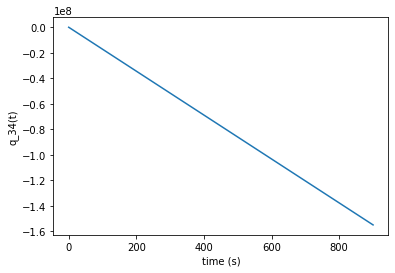

In [32]:
x = []
y = []
for i in np.linspace(0, 15*60, 1000):
    x.append(i)
    y.append(q34dot(i))
plt.plot(x, y)
plt.xlabel("time (s)")
plt.ylabel("q_34(t)")
plt.show()